## Adding the Dolfinx library to the colab environment

In [ ]:
 !wget "https://fem-on-colab.github.io/releases/fenicsx-install-real.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh"

## Adding the Gmsh library to the colab environment

In [ ]:
!wget "https://fem-on-colab.github.io/releases/gmsh-install.sh" -O "/tmp/gmsh-install.sh" && bash "/tmp/gmsh-install.sh"

## Importing the required libraries

In [ ]:
from mpi4py import MPI
from dolfinx import mesh, fem, io, plot, nls, log, geometry, la
from dolfinx import cpp as _cpp
from dolfinx import default_real_type
import basix
import dolfinx.fem.petsc
import ufl
import numpy as np
from petsc4py.PETSc import ScalarType
from petsc4py import PETSc
import time
import os
import gmsh

log.set_log_level(log.LogLevel.ERROR)
comm = MPI.COMM_WORLD
comm_rank = MPI.COMM_WORLD.rank

## Setting material properties and geometry dimensions


In [ ]:
# Material properties
E, nu = ScalarType(100000), ScalarType(0.2)	                                      #Young's modulus and Poisson's ratio
mu, lmbda, kappa = E/(2*(1 + nu)), E*nu/((1 + nu)*(1 - 2*nu)), E/(3*(1 - 2*nu))
Gc= ScalarType(1)	                                                                #Critical energy release rate
sts, scs= ScalarType(200), ScalarType(1000)	                                      #Tensile strength and compressive strength
shs = (2/3)*sts*scs/(scs-sts)
Wts = sts**2/(2*E)
Whs = shs**2/(2*kappa)


#Irwin characteristic length
lch=3*Gc*E/8/(sts**2)
#The regularization length
eps=0.25                                                                          #epsilon should not be chosen to be too large compared to lch. Typically eps<4*lch should work

h=eps/5

delta=(1+3*h/(8*eps))**(-2) * ((sts + (1+2*np.sqrt(3))*shs)/((8+3*np.sqrt(3))*shs)) * 3*Gc/(16*Wts*eps) + (1+3*h/(8*eps))**(-1) * (2/5)

#Geometry of the Brazilian test
Dia = 50
Diaeff=Dia*3

## Generating the mesh with element size $h=\frac{ϵ}{5}$
We also save the mesh in xdmf format.

In [ ]:
gmsh.initialize()
gmsh.model.add("Brazilian")
gmsh.model.setCurrent("Brazilian")

circle_dim_tags = gmsh.model.occ.addDisk(0,0,0, Dia/2, Dia/2)
gmsh.model.occ.synchronize()

# Add physical tag 1 for exterior surfaces
boundary = gmsh.model.getBoundary([(2, circle_dim_tags)])
boundary_ids = [b[1] for b in boundary]
gmsh.model.addPhysicalGroup(1, boundary_ids, tag=1)
gmsh.model.setPhysicalName(1, 1, "boundary of circle")

# Add physical tag 2 for the volume
volume_entities = [model[1] for model in gmsh.model.getEntities(2)]  ## here it just choose the main body
gmsh.model.addPhysicalGroup(2, volume_entities, tag=2)
gmsh.model.setPhysicalName(2, 2, "circle area")

# Generating Mesh
gmsh.option.setNumber("Mesh.CharacteristicLengthMin",h)
gmsh.option.setNumber("Mesh.CharacteristicLengthMax",h)
gmsh.model.mesh.generate(2)
gmsh.model.mesh.setOrder(1)

domain, cell_markers, facet_markers = io.gmshio.model_to_mesh(gmsh.model, comm, comm_rank, gdim=2)

gmsh.finalize()


with dolfinx.io.XDMFFile(domain.comm, "refined_mesh.xdmf", "w") as xdmf:
    xdmf.write_mesh(domain)

## Defining the function spaces

In [ ]:
# Define function space
V = fem.functionspace(domain, ("CG", 1, (domain.geometry.dim,)))                  #Function space for u
Y = fem.functionspace(domain, ("CG", 1))                                          #Function space for z

V_plot = fem.functionspace(domain, ("CG", 1, (domain.geometry.dim,)))             #Function space for u_plot

## Setting the contact boundary conditions

In [ ]:
maxdisp = 0.8

def loading1(x, t):
    R = Dia/2
    Reff = Diaeff/2
    disp = maxdisp
    return (np.abs(x[0]*x[0]+x[1]*x[1]-R*R)<1e-4) & (np.abs(x[0])<np.sqrt(disp*t*Reff/2)+0.03) & (x[1]>0)

def loading2(x, t):
    R=Dia/2
    Reff=Diaeff/2
    disp = maxdisp
    return (np.abs(x[0]*x[0]+x[1]*x[1]-R*R)<1e-4) & (np.abs(x[0])<np.sqrt(disp*t*Reff/2)+0.03) & (x[1]<0)

def right(x):
    R=Dia/2
    return (abs(x[1]-0)<1e-4) & (abs(abs(x[0])-R)<1e-4)

def top(x):
    R=Dia/2
    return (np.abs(np.abs(x[1])-R)<1e-4) & (np.abs(x[0]-0)<1e-4)

def center(x):
    return (np.abs(x[1]-0)<1e-4) & (np.abs(x[0]-0)<1e-4)

def outer(x):
    return (np.abs(x[0])>27.0)

class MyExpression:
    def __init__(self):
        self.t = 0.0
        self.disp = maxdisp
        self.R = Diaeff/2

    def eval(self, x):
        values = np.zeros((1, x.shape[1]))
        values[0,:] = -self.t*self.disp+(x[0]*x[0])/(2*self.R)
        return values

class MyExpression2:
    def __init__(self):
        self.t = 0.0
        self.disp = maxdisp
        self.R = Diaeff/2

    def eval(self, x):
        values = np.zeros((1, x.shape[1]))
        values[0,:] = self.t*self.disp+(x[0]*x[0])/(2*self.R)
        return values

V_1, _ = V.sub(1).collapse()

re1 = MyExpression()
re1.t = 0
c1 = fem.Function(V_1)
c1.interpolate(re1.eval)

re2 = MyExpression2()
re2.t = 0
c2 = fem.Function(V_1)
c2.interpolate(re2.eval)

def loading1_func(y):
    def partial_func1(x):
        return loading1(x, y)
    return partial_func1
def loading2_func(y):
    def partial_func2(x):
        return loading2(x, y)
    return partial_func2

fdim = domain.topology.dim -1
loading1_facets = mesh.locate_entities_boundary(domain, fdim, loading1_func(0))
loading2_facets = mesh.locate_entities_boundary(domain, fdim, loading2_func(0))
right_facets = mesh.locate_entities_boundary(domain, fdim, right)
top_facets = mesh.locate_entities_boundary(domain, fdim, top)
center_facets = mesh.locate_entities(domain, fdim, center)
outer_facets = mesh.locate_entities(domain, fdim, outer)


dofs_loading1 = fem.locate_dofs_topological((V.sub(1), V_1), fdim, loading1_facets)
dofs_loading2 = fem.locate_dofs_topological((V.sub(1), V_1), fdim, loading2_facets)
dofs_top = fem.locate_dofs_topological(V.sub(0), fdim, top_facets)
dofs_right = fem.locate_dofs_topological(V.sub(1), fdim, right_facets)


dofs_outer = fem.locate_dofs_topological(Y, fdim, outer_facets)


bcl1 = fem.dirichletbc(c1, dofs_loading1, V.sub(1))
bcl2 = fem.dirichletbc(c2, dofs_loading2, V.sub(1))
bct = fem.dirichletbc(ScalarType(0), dofs_top, V.sub(0))
bcr = fem.dirichletbc(ScalarType(0), dofs_right, V.sub(1))

bcs = [bcl1, bcl2, bct]


bct_z = fem.dirichletbc(ScalarType(1), dofs_outer, Y)
bcs_z = [bct_z]

## Defining trial and test functions and the normal vector to the boundary

In [ ]:
metadata = {"quadrature_degree": 4}
n=ufl.FacetNormal(domain)
dx = ufl.Measure("dx", domain=domain, metadata=metadata)

# Define functions
du = ufl.TrialFunction(V)                                                         # Incremental displacement
v  = ufl.TestFunction(V)                                                          # Test function
u  = fem.Function(V, name="displacement")                                         # Displacement from previous iteration
u_inc = fem.Function(V)
dz = ufl.TrialFunction(Y)                                                         # Incremental phase field
y  = ufl.TestFunction(Y)                                                          # Test function
z  = fem.Function(Y, name="phasefield")                                           # Phase field from previous iteration
z_inc = fem.Function(Y)
d = len(u)

## Setting the initial conditions

In [ ]:
##############################################################
#Initialisation of displacement field,u and the phase field,z
##############################################################

u.x.array[:] = 0.
fem.petsc.set_bc(u.vector, bcs)


z.x.array[:] = 1.
fem.petsc.set_bc(z.vector, bcs_z)


u_prev = fem.Function(V)
u_prev.x.array[:] = u.x.array
z_prev = fem.Function(Y)
z_prev.x.array[:] = z.x.array
z_trial = fem.Function(Y)
z_trial.x.array[:] = z.x.array
zdif = fem.Function(Y)
zdif.x.array[:] = 0

y_dofs_top = fem.locate_dofs_topological(V.sub(1), fdim, loading1_facets)

## Defining a function to do an interpolation for any field for visualization purposes

In [ ]:
def local_project(v, V):
    """[summary]
        Helper function to do a interpolation
    Args:
        v ([dolfin.Funcion]): [function to be projected]
        V ([dolfin.Function]): [target `dolfin.FunctionSpace` to be projected on]

    Returns:
        [dolfin.Function]: [target function after projection]
    """
    expr = fem.Expression(v, V.element.interpolation_points(), comm)
    u = fem.Function(V)
    u.interpolate(expr)
    return u

## Defining a function to evaluate any field in parallel for post-processing

In [ ]:
def adjust_array_shape(input_array):
    if input_array.shape == (2,):                                                 # Check if the shape is (2,)
        adjusted_array = np.append(input_array, 0.0)                              # Append 0.0 to the array
        return adjusted_array
    else:
        return input_array
bb_tree = geometry.bb_tree(domain, domain.topology.dim)

def evaluate_function(u, x):
    """[summary]
        Helps evaluated a function at a point `x` in parallel
    Args:
        u ([dolfin.Function]): [function to be evaluated]
        x ([Union(tuple, list, numpy.ndarray)]): [point at which to evaluate function `u`]

    Returns:
        [numpy.ndarray]: [function evaluated at point `x`]
    """


    if isinstance(x, np.ndarray):
        # If x is already a NumPy array
        points0 = x
    elif isinstance(x, (tuple, list)):
        # If x is a tuple or list, convert it to a NumPy array
        points0 = np.array(x)
    else:
        # Handle the case if x is of an unsupported type
        points0 = None

    points = adjust_array_shape(points0)

    u_value = []

    cells = []
    # Find cells whose bounding-box collide with the the points
    cell_candidates = geometry.compute_collisions_points(bb_tree, points)
    # Choose one of the cells that contains the point
    colliding_cells = geometry.compute_colliding_cells(domain, cell_candidates, points)




    if len(colliding_cells.links(0)) > 0:
        u_value = u.eval(points, colliding_cells.links(0)[0])
        u_value = domain.comm.gather(u_value, root=0)


    return u_value[0]

## Defining the stored-energy, strain, and stress functions
We also add the balance of linear momentum

In [ ]:
##Stored energy, strain and stress functions in linear isotropic elasticity (plane stress)


def energy(v):
	  return mu*(ufl.inner(ufl.sym(ufl.grad(v)),ufl.sym(ufl.grad(v))) + ((nu/(1-nu))**2)*(ufl.tr(ufl.sym(ufl.grad(v))))**2 )+ 0.5*(lmbda)*(ufl.tr(ufl.sym(ufl.grad(v)))*(1-2*nu)/(1-nu))**2

def epsilon(v):
	return ufl.sym(ufl.grad(v))

def sigma(v):
	return 2.0*mu*ufl.sym(ufl.grad(v)) + (lmbda)*ufl.tr(ufl.sym(ufl.grad(v)))*(1-2*nu)/(1-nu)*ufl.Identity(len(v))

def sigmavm(sig,v):
	return ufl.sqrt(1/2*(ufl.inner(sig-1/3*ufl.tr(sig)*ufl.Identity(len(v)), sig-1/3*ufl.tr(sig)*ufl.Identity(len(v))) + (1/9)*ufl.tr(sig)**2 ))


eta = 1e-6
# Stored energy function
psi1 = (z**2+eta)*(energy(u))
psi11 = 2*z*energy(u)
# Total potential energy
Pi = psi1*dx
# Compute first variation of Pi (directional derivative about u in the direction of v)
R = ufl.derivative(Pi, u, v)
# Compute Jacobian of R
Jac = ufl.derivative(R, u, du)
Jac3=ufl.inner(ufl.grad(du),ufl.grad(v))*dx

## Defining the external force $c_{e}$ in the phase-field equation

In [ ]:
I1 = (z**2)*ufl.tr(sigma(u))
SQJ2 = (z**2)*sigmavm(sigma(u),u)

alpha1 = (delta*Gc)/(shs*8*eps) - (2*Whs)/(3*shs)
alpha2 = (3**0.5*(3*shs - sts)*delta*Gc)/(shs*sts*8*eps) + (2*Whs)/(3**0.5*shs) - (2*3**0.5*Wts)/(sts)

ce= alpha2*SQJ2 + alpha1*I1 - z*(1-ufl.sqrt(I1**2)/I1)*psi11

## Weak form of PDE for phase-field

In [ ]:
# Weak form of PDE for phase-field
pen=1000*(3*Gc/8/eps)*ufl.conditional(ufl.lt(delta,1),1, delta)
Wv=pen/2*((abs(z)-z)**2 + (abs(1-z) - (1-z))**2 )*dx
Wv2=ufl.conditional(ufl.le(z, 0.1), 1, 0)*100*pen/2*((1/4)*(abs(z_prev-z)-(z_prev-z))**2)*dx
R_z = y*2*z*(psi11)*dx + y*(ce)*dx + 3*delta*Gc/8*(-y/eps + 2*eps*ufl.inner(ufl.grad(z),ufl.grad(y)))*dx + ufl.derivative(Wv,z,y) +  ufl.derivative(Wv2,z,y)

# Compute Jacobian of R_z
Jac_z = ufl.derivative(R_z, z, dz)

## Defining a class for solving nonlinear PDEs

In [ ]:
class NonlinearPDEProblem:
    """Nonlinear problem class for  PDEs."""

    def __init__(self, F, u, bc, J):
        self.L = fem.form(F)
        self.a = fem.form(J)
        self.bc = bc

    def form(self, x):
        x.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)

    def F(self, x, b):
        """Assemble residual vector."""
        with b.localForm() as b_local:
            b_local.set(0.0)
        fem.petsc.assemble_vector(b, self.L)
        fem.petsc.apply_lifting(b, [self.a], bcs=[self.bc], x0=[x], scale=-1.0)
        b.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
        fem.petsc.set_bc(b, self.bc, x, -1.0)

    def J(self, x, A):
        """Assemble Jacobian matrix."""
        A.zeroEntries()
        fem.petsc.assemble_matrix(A, self.a, bcs=self.bc)
        A.assemble()

    def matrix(self):
        return fem.petsc.create_matrix(self.a)

    def vector(self):
        return fem.petsc.create_vector(self.L)

## Setting the time step parameters

In [ ]:
#time-stepping parameters
T=1
Totalsteps=500
startstepsize=1/Totalsteps
stepsize=startstepsize
t=stepsize
step=1
rtol=1e-8
printsteps=10

samesizecount=1
#other time stepping parameters
terminate=0
terminate2=0
minstepsize=startstepsize/10000
maxstepsize=startstepsize

## Creating Newton solvers and their customizations

In [ ]:
# Create nonlinear problem
problem_u = NonlinearPDEProblem(R, u, bcs, Jac)

# Create Newton solver and solve

solver = _cpp.nls.petsc.NewtonSolver(MPI.COMM_WORLD)
solver.setF(problem_u.F, problem_u.vector())
solver.setJ(problem_u.J, problem_u.matrix())
solver.set_form(problem_u.form)
solver.max_it = 10
#solver.convergence_criterion = "incremental"
solver.error_on_nonconvergence = False
solver.atol = 1.0e-8
solver.rtol = 1.0e-7

ksp1 = solver.krylov_solver
opts = PETSc.Options()  # type: ignore
option_prefix = ksp1.getOptionsPrefix()
opts[f"{option_prefix}ksp_type"] = "cg"
opts[f"{option_prefix}pc_type"] = "gamg"

# Create nonlinear problem
problem_z = NonlinearPDEProblem(R_z, z, bcs_z, Jac_z)

# Create Newton solver and solve

solver_z = _cpp.nls.petsc.NewtonSolver(MPI.COMM_WORLD)
solver_z.setF(problem_z.F, problem_z.vector())
solver_z.setJ(problem_z.J, problem_z.matrix())
solver_z.set_form(problem_z.form)
solver_z.max_it = 10
#solver_z.convergence_criterion = "incremental"
solver_z.error_on_nonconvergence = False
solver_z.atol = 1.0e-8
solver_z.rtol = 1.0e-7


ksp2 = solver_z.krylov_solver
opts = PETSc.Options()  # type: ignore
option_prefix = ksp2.getOptionsPrefix()
opts[f"{option_prefix}ksp_type"] = "cg"
opts[f"{option_prefix}pc_type"] = "gamg"

## Solving the problem over several time steps via a staggered scheme

In [ ]:
while t-stepsize < T:


    terminate=0

    if comm_rank==0:
        print('Step= %d' %step, 't= %f' %t, 'Stepsize= %e' %stepsize)


    re1.t=t
    c1.interpolate(re1.eval)
    re2.t=t
    c2.interpolate(re2.eval)
    loading1_facets = mesh.locate_entities_boundary(domain, fdim, loading1_func(t))
    loading2_facets = mesh.locate_entities_boundary(domain, fdim, loading2_func(t))
    dofs_loading1 = fem.locate_dofs_topological((V.sub(1), V_1), fdim, loading1_facets)
    dofs_loading2 = fem.locate_dofs_topological((V.sub(1), V_1), fdim, loading2_facets)
    bcl1 = fem.dirichletbc(c1, dofs_loading1, V.sub(1))
    bcl2 = fem.dirichletbc(c2, dofs_loading2, V.sub(1))
    bct = fem.dirichletbc(ScalarType(0), dofs_top, V.sub(0))
    bcr = fem.dirichletbc(ScalarType(0), dofs_right, V.sub(1))


    problem_u.bc = [bcl1, bcl2, bct]


    y_dofs_top = fem.locate_dofs_topological(V.sub(1), fdim, loading1_facets)
    stag_iter = 1
    rnorm_stag = 1
    norm_z = 1
    while stag_iter<50 and norm_z > 1e-7:
        start_time=time.time()
        ##############################################################
        # PDE for u
        ##############################################################
        solver.solve(u.vector)
        u.x.scatter_forward()
        z_trial.x.array[:] = z.x.array
        ##############################################################
        # PDE for z
        ##############################################################
        solver_z.solve(z.vector)
        z.x.scatter_forward()
        ##############################################################

        zmin = domain.comm.allreduce(np.min(z.x.array), op=MPI.MIN)


        if comm_rank==0:
            print(zmin)

        if comm_rank==0:
            print("--- %s seconds ---" % (time.time() - start_time))

        ###############################################################
        #Residual check for stag loop
        ###############################################################
        b_e = fem.petsc.assemble_vector(fem.form(-R))
        fint=b_e.copy()
        fem.petsc.set_bc(b_e, bcs)

        rnorm_stag=b_e.norm()
        zdif.x.array[:] = z.x.array - z_trial.x.array
        norm_z = zdif.x.norm()
        if comm_rank==0:
            print('Iteration number for u= %d' %stag_iter,  'Residual= %e' %rnorm_stag)
            print('Iteration number for z= %d' %stag_iter,  'Residual= %e' %norm_z)
        stag_iter+=1

    ########### Post-processing ##############

    if terminate==1:
        u.x.array[:] = u_prev.x.array
        z.x.array[:] = z_prev.x.array
    else:
        u_prev.x.array[:] = u.x.array
        z_prev.x.array[:] = z.x.array

        ####Calculate Reaction
        Fx=domain.comm.allreduce(np.sum(b_e[y_dofs_top]), op=MPI.SUM)
        z_x = evaluate_function(z, (0.0,0.0))

        if comm_rank==0:
            print(Fx)
            print(z_x)
            with open('PF_R15S5_formula.txt', 'a') as rfile:
                rfile.write("%s %s %s\n" % (str(t), str(zmin), str(Fx)))

        if step % printsteps==0:
            u.name = "Deformation"
            z.name = "phasefield"
            with io.XDMFFile(domain.comm, "paraview/2D_Ratio40checkeps2_" + str(step) + ".xdmf", "w") as file_results:
                file_results.write_mesh(domain)
                file_results.write_function(u, t)
                file_results.write_function(z, t)


    #time stepping
    if terminate==1:
        if stepsize>minstepsize:
            t-=stepsize
            stepsize/=2
            t+=stepsize
            samesizecount=1
        else:
            break
    else:
        if samesizecount<2:
            step+=1
            if t+stepsize<=T:
                samesizecount+=1
                t+=stepsize
            else:
                samesizecount=1
                stepsize=T-t
                t+=stepsize
        else:
            step+=1
            if stepsize*2<=maxstepsize and t+stepsize*2<=T:
                stepsize*=2
                t+=stepsize
            elif stepsize*2>maxstepsize and t+maxstepsize<=T:
                stepsize=maxstepsize
                t+=stepsize
            else:
                stepsize=T-t
                t+=stepsize
                samesizecount=1

## Results
Plot of the normalized force in terms of the normalized applied displacement. Snapshot of the phase field at fracture.

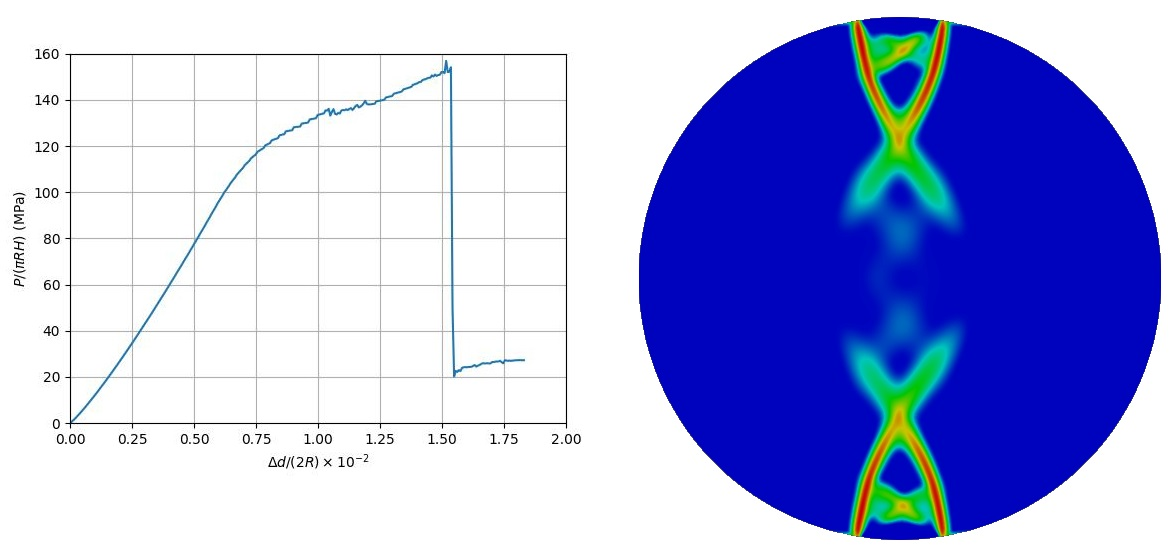